In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scanpy as sc
import bambi as bmb

from tl._exp_dist import exp_dist

from patsy import dmatrix

In [2]:
RANDOM_SEED = 8927

In [3]:
adata = sc.read_h5ad("C://backup/Bachelorarbeit/LiverAgeing_pp_lowres.h5ad")

In [4]:
adata.obs["vein_type"] = "lobular_axis"
pv = list(adata[adata.obs["umap_spline"] <= 0.2].obs.index)
cv = list(adata[adata.obs["umap_spline"] >= 0.9].obs.index)
adata.obs.loc[adata.obs.index.isin(pv), "vein_type"]  = "pv"
adata.obs.loc[adata.obs.index.isin(cv), "vein_type"]  = "cv"

adata = adata[:, adata.var.highly_variable]

In [5]:
df = exp_dist(adata, groups="pv", cluster_key="vein_type",batch_key="mouse_id", covariates='age', copy=True)

c:\Users\laure\anaconda3\envs\pymc_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [6]:
df["Cyp2e1"] = sc.get.obs_df(adata, "Cyp2e1").to_numpy()
df = df.sort_values('pv')

In [7]:
df = df[["pv", "age", "Cyp2e1"]]

In [8]:
df

,pv,age,Cyp2e1
3x20-37_30_C2,0.000000,young,1.571988
15x27-37_30_C1,0.000000,young,0.000000
15x26-37_30_C1,0.000000,young,1.130277
14x24-37_30_C3,0.000000,young,1.149204
3x23-37_43_A1,0.000000,old,1.839577
...,...,...,...
32x36-37_43_C2,0.971243,young,4.347907
36x3-37_43_C1,0.990960,young,4.889580
36x2-37_43_C1,0.992274,young,5.120665
36x1-37_43_C1,0.997471,young,4.834760


In [17]:
import patsy
age = patsy.dmatrices("Cyp2e1 ~ age ", df, return_type='dataframe')[1]

In [21]:
age

,Intercept,age[T.young]
3x20-37_30_C2,1.0,1.0
15x27-37_30_C1,1.0,1.0
15x26-37_30_C1,1.0,1.0
14x24-37_30_C3,1.0,1.0
3x23-37_43_A1,1.0,0.0
...,...,...
32x36-37_43_C2,1.0,1.0
36x3-37_43_C1,1.0,1.0
36x2-37_43_C1,1.0,1.0
36x1-37_43_C1,1.0,1.0


In [22]:
df['age'] = age['age[T.young]']
df

,pv,age,Cyp2e1
3x20-37_30_C2,0.000000,1.0,1.571988
15x27-37_30_C1,0.000000,1.0,0.000000
15x26-37_30_C1,0.000000,1.0,1.130277
14x24-37_30_C3,0.000000,1.0,1.149204
3x23-37_43_A1,0.000000,0.0,1.839577
...,...,...,...
32x36-37_43_C2,0.971243,1.0,4.347907
36x3-37_43_C1,0.990960,1.0,4.889580
36x2-37_43_C1,0.992274,1.0,5.120665
36x1-37_43_C1,0.997471,1.0,4.834760


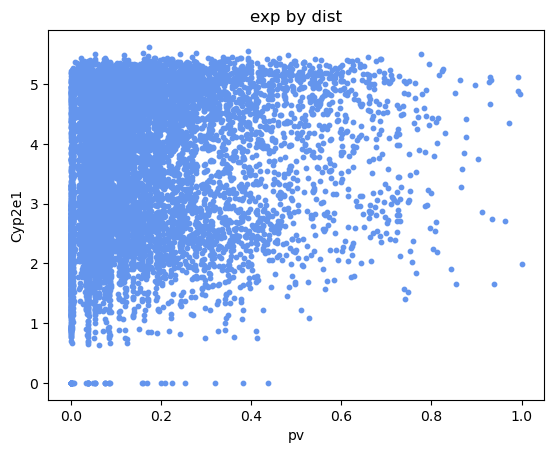

In [9]:
df.plot.scatter(
    "pv", "Cyp2e1", color="cornflowerblue", s=10, title="exp by dist"
);

In [23]:
num_knots = 15
knot_list = np.quantile(df.pv, np.linspace(0, 1, num_knots))
knot_list

array([0.        , 0.00209939, 0.03150521, 0.03821962, 0.05372713,
       0.06302602, 0.08173108, 0.09702933, 0.11961374, 0.13924573,
       0.17106142, 0.21615409, 0.27791127, 0.39842383, 1.        ])

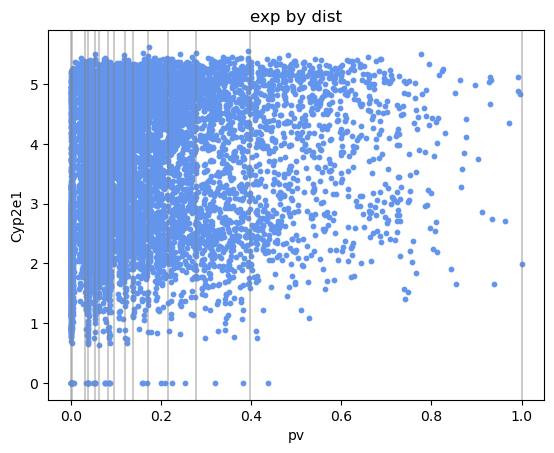

In [11]:
df.plot.scatter(
    "pv", "Cyp2e1", color="cornflowerblue", s=10, title="exp by dist"
);
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [26]:
B = dmatrix(
    "bs(pv, knots=knots, degree=3, include_intercept=True) - 1",
    {"pv": df.pv.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (12317, 17)
  Columns:
    ['bs(pv, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(pv, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(pv, knots=knots, degree=3, inc

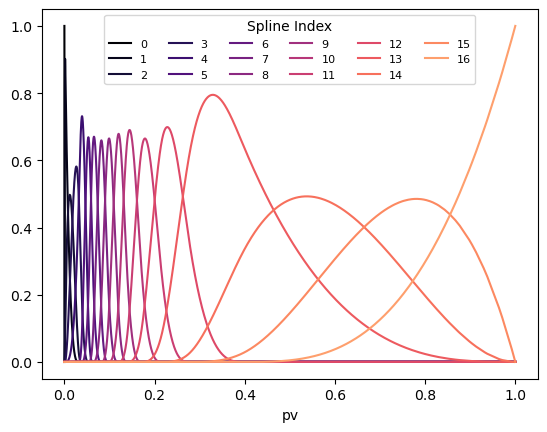

In [27]:
spline_df = (
    pd.DataFrame(B)
    .assign(pv=df.pv.values)
    .melt("pv", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("pv", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

In [14]:
np.arange(B.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [51]:
np.asarray(B, order="F").T.shape

(17, 12317)

In [52]:
df.age.shape

(12317,)

In [53]:
np.dot(df.age.T, np.asarray(B, order="F"))

array([486.04826501, 451.6544525 , 126.23509902, 231.00232878,
       616.70648731, 279.41701053, 240.19110592, 286.82397055,
       193.9936379 , 234.21933696, 275.89641905, 333.68891254,
       475.03930677, 798.88201392, 414.37806315, 182.69312936,
        50.13046075])

In [78]:

with pm.Model() as spline_model:
    spline_model.add_coord("splines", np.arange(B.shape[1]), mutable = True)
    #a = pm.Normal("a", 100, 5)
    #w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    #w = np.dot(df.age.T, np.asarray(B, order="F")).astype(int)
    mu = pm.Deterministic("mu", pm.math.dot(np.asarray(B, order="F"), np.dot(df.age.T, np.asarray(B, order="F")).astype(int)))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=df.Cyp2e1)


In [67]:
w

array([486, 451, 126, 231, 616, 279, 240, 286, 193, 234, 275, 333, 475,
       798, 414, 182,  50])

In [79]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [D]


In [70]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [81]:
az.summary(idata, var_names=["mu", "sigma"])

c:\Users\laure\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],486.000,0.000,486.000,486.000,0.000,0.000,4000.0,4000.0,NaN
mu[1],486.000,0.000,486.000,486.000,0.000,0.000,4000.0,4000.0,NaN
mu[2],486.000,0.000,486.000,486.000,0.000,0.000,4000.0,4000.0,NaN
mu[3],486.000,0.000,486.000,486.000,0.000,0.000,4000.0,4000.0,NaN
mu[4],486.000,0.000,486.000,486.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
mu[12313],55.992,0.000,55.992,55.992,0.000,0.000,4000.0,4000.0,NaN
mu[12314],55.116,0.000,55.116,55.116,0.000,0.000,4000.0,4000.0,NaN
mu[12315],51.668,0.000,51.668,51.668,0.000,0.000,4000.0,4000.0,NaN
mu[12316],50.000,0.000,50.000,50.000,0.000,0.000,4000.0,4000.0,NaN


In [82]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(pv=df.pv.values)
    .melt("pv", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(pv=df.pv.values)
    .melt("pv", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("pv", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("pv", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

KeyError: 'w'

In [83]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
blossom_data_post = df.copy().reset_index(drop=True)
blossom_data_post["pred_mean"] = post_pred["mean"]
blossom_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
blossom_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

c:\Users\laure\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


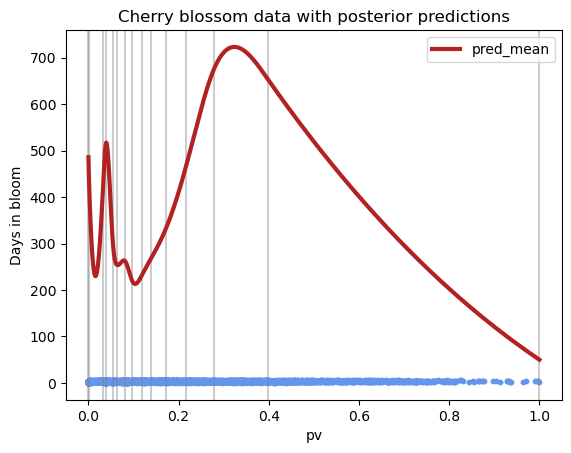

In [84]:
df.plot.scatter(
    "pv",
    "Cyp2e1",
    color="cornflowerblue",
    s=10,
    title="Cherry blossom data with posterior predictions",
    ylabel="Days in bloom",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

blossom_data_post.plot("pv", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    blossom_data_post.pv,
    blossom_data_post.pred_hdi_lower,
    blossom_data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

In [ ]:
post_pred

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,2.080,0.043,1.998,2.156,0.001,0.000,5821.0,2655.0,1.0
1,2.080,0.043,1.998,2.156,0.001,0.000,5821.0,2655.0,1.0
2,2.080,0.043,1.998,2.156,0.001,0.000,5821.0,2655.0,1.0
3,2.080,0.043,1.998,2.156,0.001,0.000,5821.0,2655.0,1.0
4,2.080,0.043,1.998,2.156,0.001,0.000,5821.0,2655.0,1.0
...,...,...,...,...,...,...,...,...,...
12312,3.732,0.299,3.161,4.273,0.006,0.004,2797.0,2810.0,1.0
12313,3.708,0.349,3.039,4.335,0.007,0.005,2690.0,2752.0,1.0
12314,3.706,0.353,3.028,4.338,0.007,0.005,2684.0,2792.0,1.0
12315,3.699,0.367,2.987,4.350,0.007,0.005,2660.0,2751.0,1.0
